### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2017 ###

# Neighborhood Inference in Ellipse Fitting #

#### Andrew Schoen (aschoen2@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
  1. [Utility Functions](#3.A-Utility-Functions)
  1. [Data Generation](#3.B-Data-Generation)
  1. [Fitting Functions](#3.C-Fitting-Functions)
  1. [Fitting of a Single Ellipse](#3.D-Fitting-of-a-Single-Ellipse)
  1. [Fitting of a Series of Ellipses](#3.E-Fitting-of-a-Series-of-Ellipses)
1. [Results and Discussion](#4.-Results-and-Discussion)
  1. [Lambdas](#4.A-Lambdas)
  1. [To use Neighborhood Inference, or Not?](#4.B-To-use-Neighborhood-Inference,-or-Not?)
  1. [Thoughts on the Model](#4.C-Thoughts-on-the-Model)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

In this project, I seek to replicate and expand on the ellipsoid-fitting procedure for Diffusion-Tensor Imaging [(Alexander et al.)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2041910/), a technique of Magnetic Resonance Imaging (MRI) which maps out water flow in the brain. They do this by looking at 3-dimensional sections of the brain called voxels, and map out the pattern of water diffusion in each voxel. This diffusion pattern seen can be represented by an ellipsoid. 

Raw Vectors                |  Fitted Ellipse
:-------------------------:|:-------------------------:
![fixit diffusion][diffusionvectors]  |  ![fixit diffusion][diffusion]
 
Spherical or near-spherical patterns represent unrestricted diffusion, whereas stretched ellipsoids represent water that is constrained in some way. In the context of brain anatomy, this constraint on water flow is generally the cellular walls of neuron axons, seen below:

|Neuron Diagram          |
|:----------------------:|
|![fixit neuron][neuron] |

_Note, the length of the axon in this diagram is not to scale. Axons can be extremely long, such that they constitute the majority of the cell. For example, neurons can stretch the entire length of the spine._ 

These long axons are arranged in bundles called fibres, creating the "highways" of information transfer in the brain. The effect of the constraint on diffusion by these fibres is measurable in DTI; long, narrow ellipses indicate strong, well organized fibres, whereas more spherical ellipses indicate more of a diffuse cris-cross of neurons. Thus, this imaging technique offers insight into the structure and organization of neuron fibres in the brain, allowing us to see these "highways":

![fixit tractography][tractography]

The difficulty, however, is that MRI produces data with high amounts of noise and bias. Due to the nature of the DTI process, it is even more susceptible than standard MRI to these effects. Various methods are constantly being created and tested to help reduce the effect of this noise and bias [(Mohammadi et al)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3792745/).

The purpose of this project is to test the efficacy of neighborhood inference on this fitting process. In other words, we try improving the quality of the essential ellipsoid-fitting procedure by using each voxel's neighbor to improve the quality of its own estimation. This means that adjacent ellipsoids should have similar features as one another. This is justified in that neighboring areas in the brain do have similar characteristics, as in the vector field below:

![fixit vectorfield][vectorfield]

By leveraging the characteristics of neighbors of a given ellipsoid, we can hopefully augment the estimation of each voxel's best-fitting ellipsoid, especially in cases where a single instance may act as an outlier, or there is considerable noise in the measurements used to estimate it.

In order to test this, I have simplified the actual procedure in the following ways: 
1. The shapes being fitted in standard DTI are ellipsoids, existing in 3 dimensions. In order to ease visualization and testing, I have simplified this to the 2-dimensional space with ellipses. This means that the diffusion ellipses can be represented by three values, _a_, _b_, and _θ_, referred to as the major axis, minor axis, and angle of rotation, respectively: ![fixit ellipsediagram][ellipsediagram]. 
1. The standard procedure for DTI involves choosing a direction, $\phi$, and measuring the observed diffusion in that direction: ![fixit directions][directions] In standard DTI, these directions are thoughtfully considered, but for computational ease, they have in this project been instead sampled from a uniform distribution between $0$ and $\pi$.
1. Finally, voxels have neighbors on 6 sides, unless on an edge or corner of the image. This has been simplified to a maximum of 2 sides (a line of ellipses) as a proof-of-concept. This produces an 1-dimensional array of ellipses.

For the purposes of this report, I will define the following terms explicitly:

To this end, I will be generating our own data to approximate the types of signals coming from each voxel in a DTI image. This allows for the dynamic adjustment of noise, angle, and ellipse shape, and a proper assessment of how robust the system is to these types of adjustments. 

The process will be as follows. First, this project will demonstrate the fitting of a single ellipse, as this is the building block for later developments. At this point, noise and shape parameters will be tested for robustness. With that completed, the model will be extended to a series of ellipses, using neighborhood inference. In this way noise and shape parameters can be manipulated to test efficacy.

[neuron]: http://webspace.ship.edu/cgboer/neuron.gif
[tractography]: http://www.martinos.org/neurorecovery/images/tracts.png
[vectorfield]: VectorField.png
[ellipsediagram]: EllipseDiagram.png
[diffusion]: Diffusion.png
[diffusionvectors]: DiffusionVectors.png
[directions]: Directions.png

## 2. Mathematical model ##

Before discussing the model, it will be helpful to clarify that the following method utilizes polar coordinates, where each point in the space can be represented by the distance from the point to the origin, and the angle of that vector (in this case $\phi$). 

| Variable | Meaning |
|:--------:|:-------:|
|$a$       |The length of the major axis (long axis) of an ellipse |
|$b$       |The length of the minor axis (short axis) of an ellipse|
|$\theta$  |The angle of rotation of an ellipse |
|$r$       |The distance from a point to the origin, a polar coordinate component|
|$r_{exp}$ |The expected value of $r$ for a given $phi$ given some settings of $a$, $b$, and $theta$|
|$r_{obs}$ |The observed value of $r$ in the data for a given $phi$|
|$\phi$    |The angle between a line to the point and a zero reference line (in this case the positive y=0 axis).<br> This is the second component of a polar coordinate|
|$\lambda a$       |The regularization constant to promote adjacent ellipses having similar major axes |
|$\lambda b$       |The regularization constant to promote adjacent ellipses having similar minor axes |
|$\lambda \theta$  |The regularization constant to promote adjacent ellipses having similar angles of rotation |

As indicated in the introduction, the current model is based on a method of MRI physics for fitting ellipsoids to diffusion vectors. While it is true that each voxel is located in a different location in the image, with respect to the voxel containing the data, the ellipse itself is assumed to be centered, since the diffusion vectors (in our case the ($r_{obs}$,$\phi$) coordinates) are with respect to the voxel as a whole. Within the context of DTI, noise in the estimate each point can then be simplified to noise in the value of $r_{obs}$, since $\phi$ is known for each point.
An assumption of the current algorithm is that noise in the noise of $r_{obs}$ follows a gaussian about the actual value, regardless of the shape of the ellipsoid/ellipse. This however is not strictly true, as in practice noise tends to be largest along the direction of the major axis, $a$.

To fit ellipses, I will employ a method of $L_2$-regularized nonlinear least squares. For each ellipse, there are 3 decision variables: $a$, $b$, and $\theta$. 
![fixit ellipsediagram][ellipsediagram]
Because of periodicity, $\theta$ is constrained to be between $0$ and $\pi$. $a$ and $b$ are both constrained to be positive, and for simplicity in designation, $a$ is the major axis, and is therefore greater than or equal to $b$. The equation for the value $r_{exp}$ in an ellipse, derived from the standard equation of an ellipse, is a function of $a$, $b$, $\theta$, and the angle $\phi$ (the query angle corresponding to the desired radius) is as follows:

<p style="text-align: center;">
$r_{exp}(a,b,\theta,\phi) = \frac{1}{\sqrt{\left ( \frac{cos(\phi-\theta)}{a} \right )^2+\left ( \frac{sine(\theta-\phi)}{b} \right )^2 }}$</p>

With this equation, we can consider for each observed $\phi$, what is the difference between the corresponding observed $r_{obs}$ and what would be expected ($r_{exp}$) given an ellipse with values $a$, $b$, and $\theta$. The sum of squared differences between $r_{obs}$ and $r_{exp}$ for each $\phi$ is then minimized to fit an individual ellipse. In standard form, it is the following:

$$
\begin{aligned}
\underset{a,b,\theta}{\text{minimize}}\qquad& \sum^{n}_{i=1} \left( r_i - \frac{1}{\sqrt{\left ( \frac{cos(\phi_i-\theta)}{a} \right )^2+\left ( \frac{sine(\theta-\phi_i)}{b} \right )^2 }} \right)^2\\
\text{subject to:}\qquad& a \ge 0\\
& b \ge 0\\
& a \ge b\\
& \pi \ge \theta \ge 0
\end{aligned}
$$

By minimizing the sum of squared differences between $r_{obs}$ and $r_{exp}$, we arrive at the best-fitting ellipse (at least one finding a local minimum).

If this model is extended to include neighborhood inference ($L_2$ regularization on the differences in $a$, $b$, and $\theta$ for adjacent ellipses, I obtain the following model:

$$
\begin{aligned}
\underset{a_{1,\dots ,m},b_{1,\dots ,m},\theta_{1,\dots ,m}}{\text{minimize}}\qquad& \sum^{m}_{j=1} \sum^{n}_{i=1} \left( r_{ij} - \frac{1}{\sqrt{\left ( \frac{cos(\phi_{ij}-\theta_j)}{a_j} \right )^2+\left ( \frac{sine(\theta_j-\phi_{ij})}{b_j} \right )^2 }} \right)^2 + \lambda_a\sum_{j=1}^{m-1} (a_j-a_{j+1})^2 + \lambda_b \sum_{j=1}^{m-1} (b_j-b_{j+1})^2 + \lambda_\theta \sum_{j=1}^{m-1} (sin(\theta_j-\theta_{j+1}))^2\\
\text{subject to:}\qquad
& a_j \ge 0   ,\space\space\space\space\space\space\space\space\space\space j=1,\dots,m\\
& b_j \ge 0   ,\space\space\space\space\space\space\space\space\space\space j=1,\dots,m\\
& a_j \ge b_j ,\space\space\space\space\space\space\space\space\space j=1,\dots,m\\
& \pi \ge \theta_j \ge 0 \space\space\space\space j=1,\dots,m\\
\end{aligned}
$$

Note the slight modification for the $\theta$ regularizer, due to the periodicity of the angles such that $\pi$ is effectively the same as $0$. By minimizing this model, we find a set of ellipses minimizing the sum of squared differences in $r_{obs}$ and $r_{exp}$ while limiting differences in adjacent $a$, $b$, and $\theta$ values.

[ellipsediagram]: EllipseDiagram.png

## 3. Solution ##

In the following section I will implement the above models using Julia's _JuMP_ and _Ipopt_, as well as some assistive modules. 

In [1]:
using JuMP, NamedArrays, PyPlot, PyCall, Distributions, Ipopt;

### 3.A Utility Functions ###
The following utility functions are defined. 

The function $get\_r$ returns a radius according to the equation:
<p style="text-align: center;">
$r_{exp}(a,b,\theta,\phi) = \frac{1}{\sqrt{\left ( \frac{cos(\phi-\theta)}{a} \right )^2+\left ( \frac{sine(\theta-\phi)}{b} \right )^2 }}$</p>

The function $get\_largest\_r$ takes in a NamedArray and returns the $\phi$ corresponding to the largest radius in that dataset. This is useful when setting initial $\theta$ values for the optimization.

In [2]:
# Utility Functions

# A simple function to get an r_exp value given a, b, θ, and ϕ
function get_r(a,b,θ,ϕ)
    return 1/sqrt((cos(ϕ-θ)/a)^2+(sin(θ-ϕ)/b)^2)
end

# A simple function to get the ϕ 
# corresponding to the largest radius in a dataset
function get_largest_r(array)
    rmax=0
    ϕmax=0
    d = size(array)[1]
    for i in 1:d
        if array[i,"Radius"] > rmax
            rmax = array[i,"Radius"]
            ϕmax = array[i,"Angle"]
        end
    end
    if ϕmax > π
        return ϕmax - π
    else
        return ϕmax
    end
end;

### 3.B Data Generation ###
These functions handle generating data to be used in the optimizations. The function $generate\_ellipses$ calls  $generate\_ellipse$, with the option of adding variation between ellipses. Variation and Noise parameters are $\sigma$ values for a distribution centered at $\mu=0$, added to the true values. Thus, setting any to zero returns a non-noisy signal.

In [3]:
# Generation Functions

# Generates a NamedArray with columns "Angle" and "Radius, 
# with rows for each ϕ.
function generate_ellipse(a,b,θ,n,noise)
    ϕ = sort(rand(n)*2*π)
    if noise == 0
        # Get the radius directly
        r = [ get_r(a,b,θ,i) for i in ϕ ]
    else
        # Get the radius, distorted by gaussian noise
        r = [ get_r(a,b,θ,i)+rand(Normal(0, noise)) for i in ϕ ]
    end
    # Concatenate to form the matrix
    ellipsematrix = hcat(ϕ,r)
    # Return the NamedArray
    return NamedArray(ellipsematrix, 
        (collect(1:n),["Angle","Radius"]),
        ("Degree","Measure"))
end

# Generates a NamedArray with columns "Angle" and "Radius, 
# with rows for each ϕ, and a 3rd dimension for each ellipse.
function generate_ellipses(a,b,θs,n,noise,variation)
    ellipses = collect(1:length(θs))
    all_data = []
    for (i, angle) in enumerate(θs)
        # Generate individual ellipse
        # If variation is true, add some variation between ellipses
        if variation == 0
            data = generate_ellipse(a,b,angle,n,noise)
        else
            data = generate_ellipse(a+rand(Normal(0, variation)),
                                    b+rand(Normal(0, variation)),
                                    angle+rand(Normal(0, variation)),
                                    n,noise)
        end
        # Build up the matrix incrementally
        if length(all_data) == 0
            all_data = data
        else
            # Concatenate on the third dimension
            all_data = cat(3, all_data, data)
        end
    end
    # Return the NamedArray
    return NamedArray(all_data, 
        (collect(1:n),["Angle","Radius"],collect(1:length(angles))),
        ("Degree","Measure","Ellipse"))
end;

### 3.C Fitting Functions ###
These are the implementations of the models defined in [Mathematical Model](#2.-Mathematical-model).

In [4]:
# Fitting Functions

# Fits a single ellipse, given a dataset from generate_ellipse()
function fit_ellipse(dataset)
    datasize = size(dataset)[1]
    m = Model(solver=IpoptSolver(print_level=0))
    @variable(m, a>=0)
    @variable(m, b>=0)
    @variable(m, π>=θ>=0)
    @constraint(m, a >= b)
    # An expression for the expected r, for ease of use.
    @NLexpression(m, est[i=1:datasize],1/sqrt((cos(dataset[i,"Angle"]-θ)/a)^2+(sin(θ-dataset[i,"Angle"])/b)^2))
    # Minimize the difference between observed and expected r
    @NLobjective(m, Min, sum((dataset[i,"Radius"]-est[i])^2 for i in 1:datasize))
    # Set a and b randomly
    setvalue(a, rand())
    setvalue(b, rand())
    # Set θ to the ϕ corresponding to the largest r
    # This helps with improving the chances of finding the
    # global minimum
    setvalue(θ, get_largest_r(dataset))
    # Solve the optimization
    s = solve(m)
    return getvalue(a), getvalue(b), getvalue(θ)
end;

# Fits a series of ellipses, given a dataset from generate_ellipses(), 
# as well as regularization constants for a, b, and θ
function fit_ellipses(dataset, λa, λb, λθ)
    datasize = size(dataset)[1]
    angles = collect(1:datasize)
    ellipses = collect(1:size(dataset)[3])
    m = Model(solver=IpoptSolver(print_level=0))
    @variable(m, a[ellipses] >= 0)
    @variable(m, b[ellipses] >= 0)
    @variable(m, π >= θ[ellipses] >= 0)
    for ellipse in ellipses
        @constraint(m, a[ellipse] >= b[ellipse])
    end
    # An expression for the expected r, for ease of use.
    @NLexpression(m, est[i=1:datasize,j=1:length(ellipses)], 1/sqrt((cos(dataset[i,"Angle",j]-θ[j])/a[j])^2+(sin(θ[j]-dataset[i,"Angle",j])/b[j])^2))
    @NLexpression(m, a_diff, sum((a[j]-a[j+1])^2 for j=1:(length(ellipses)-1)))
    @NLexpression(m, b_diff, sum((b[j]-b[j+1])^2 for j=1:(length(ellipses)-1)))
    @NLexpression(m, θ_diff, sum(sin(θ[j]-θ[j+1])^2 for j=1:(length(ellipses)-1)))
    @NLobjective(m, Min, sum((dataset[i,"Radius",j]-est[i,j])^2 for i=1:datasize,j=1:length(ellipses)) + λa*a_diff + λb*b_diff + λθ*θ_diff)
    for ellipse in ellipses
        # Set a and b randomly
        setvalue(a[ellipse], rand())
        setvalue(b[ellipse], rand())
        # Set θ to the ϕ corresponding to the largest r
        # This helps with improving the chances of finding the
        # global minimum
        setvalue(θ[ellipse], get_largest_r(dataset[:,:,ellipse]))
    end
    # Solve the optimization
    s = solve(m)
    return getvalue(a), getvalue(b), getvalue(θ)
end;

### 3.D Fitting of a Single Ellipse ###
In this section, we fit a single ellipse. Due to the non-convex nature of the optimization, initial values is extremely important. Local minimum tend to be found when $\theta = 0$, and when $a=b$. To minimize the chance that this occurs, the initial value of $\theta$ is chosen to be the $\phi$ corresponding to the largest $r_{obs}$ from the dataset. To observe the effects of noise, shape, orientation, and datasize, feel free to rerun with varying parameters.

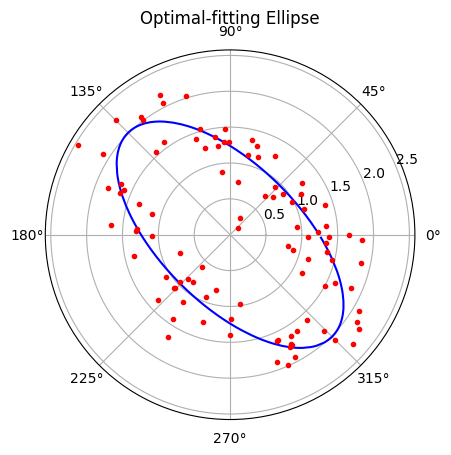

2×3 Named Array{Float64,2}
Ellipse ╲ Measure │        a         b         θ
──────────────────┼─────────────────────────────
Actual            │      2.0       1.0   2.35619
Estimated         │  2.01094  0.974565   2.35782


In [9]:
# Set these parameters
# Feel free to try out variations!
# Number of samples
datasize = 100;
# Size of the major axis
major_axis_size = 2;
# Size of the minor axis
minor_axis_size = 1;
# Angle of rotation (0 to 2π)
angle_of_rotation = 3π/4;
# Noise (Standard Deviation)
noise = .3;

# Generate and fit the ellipse
rawdata = generate_ellipse(major_axis_size,minor_axis_size,angle_of_rotation,datasize,noise)
a,b,θ = fit_ellipse(rawdata)

# Print the variables nicely
resultarray = NamedArray([major_axis_size minor_axis_size angle_of_rotation
                          a               b               θ                ], 
                        (["Actual","Estimated"],["a","b","θ"]),("Ellipse","Measure"))

# Make a graph to visualize
optdata = generate_ellipse(a,b,θ,500,0)
ax1 = subplot(1,1,1, polar=true,)
title("Optimal-fitting Ellipse")
po = plot( optdata[:,1], optdata[:,2], linestyle="-", marker="None",color="blue" ) ;
pr = plot( rawdata[:,1], rawdata[:,2], linestyle="None", marker=".",color="red") ;
ax1[:set_theta_zero_location]("E")
println(resultarray)

### 3.E Fitting of a Series of Ellipses ###
In this section we fit a series of ellipses. For simplicity, this can be configured to model no neighborhood inference by setting $\lambda a$, $\lambda b$, $\lambda \theta$ to zero. A difference between this and the previous model is that instead of a single angle being given, a range of angles is given ($angles$), and a $variation$ parameter appears. This adds noise to the actual values of the $major\_axis\_size$, $minor\_axis\_size$, and the individual $\theta$ for each ellipse. What this achieves in practice is cell noise relative to its neighbors, as opposed to noise in $r_{obs}$. 

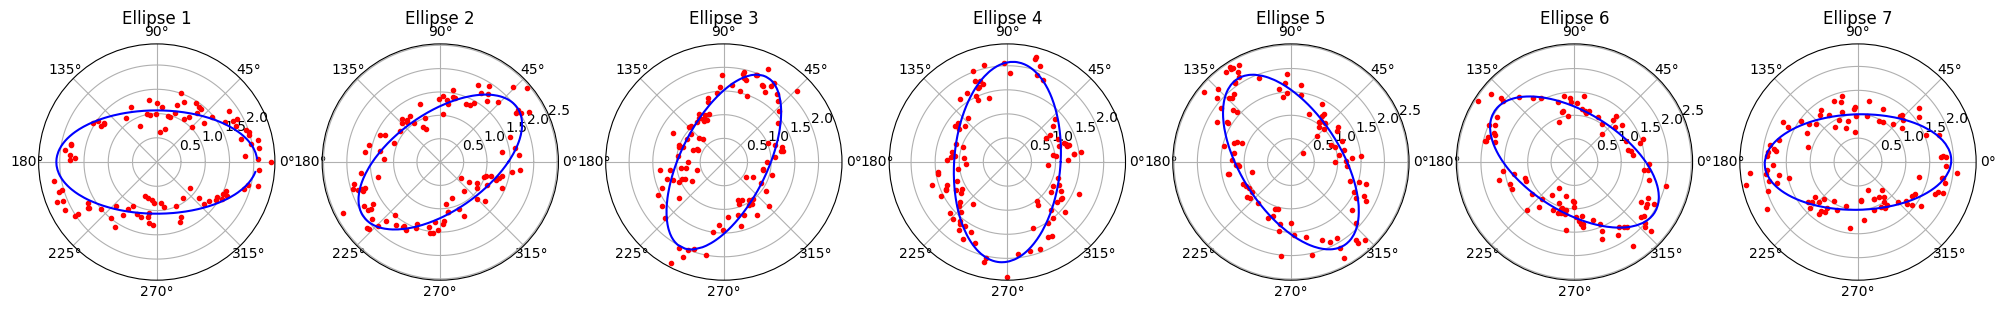

7×3 Named Array{Float64,2}
Ellipse ╲ Measure │         a          b          θ
──────────────────┼────────────────────────────────
1                 │   2.06983    1.06463    3.14159
2                 │   2.01654    1.04094   0.617912
3                 │    2.0094   0.912956    1.11079
4                 │   2.08509    1.10388    1.49498
5                 │   2.11371    1.06179    2.14353
6                 │   2.02675    1.05665     2.5788
7                 │   1.95099   0.998428  0.0258114

In [6]:
# Set these ellipse parameters
# Feel free to try out variations!
# Set the angles 
angles = collect(0:π/6:π)
# Number of samples
datasize = 100;
# Size of the major axis
major_axis_size = 2;
# Size of the minor axis
minor_axis_size = 1;
# Noise (Standard Deviation)
noise = 0.2;
# Variation between ellipses
variation = 0.1

# Set these lambda parameters
λa = 10
λb = 10
λθ = 4

# Generate and fit the ellipse
ellipses = collect(1:length(angles))
alldata = generate_ellipses(major_axis_size,minor_axis_size,angles,datasize,noise,variation)
a,b,θ = fit_ellipses(alldata,λa,λb,λθ)

# Make a graph to visualize
f1 = figure("Ellipses",figsize=(25,25))
for (i, angle) in enumerate(angles)
    ax1 = subplot(1,length(angles),i, polar=true,)
    t = title(string("Ellipse ",i))
    pl1 = plot( alldata[:,"Angle",i], alldata[:,"Radius",i], linestyle="None", marker=".",color="red") ;
    ax1[:set_theta_zero_location]("E") ;
    est_data = generate_ellipse(a[i],b[i],θ[i],500,0)
    pl1 = plot( est_data[:,"Angle"], est_data[:,"Radius"], linestyle="-", marker="None",color="blue") ;
end

# Print the variables nicely
d = []
for j in ellipses
    if d == []
        d = [a[j] b[j] θ[j]]
    else
        d = vcat(d, [a[j] b[j] θ[j]])
    end
end

resultarray = NamedArray(d, (ellipses,["a","b","θ"]),("Ellipse","Measure"))

## 4. Results and Discussion ##

### 4.A Lambdas ###

In order to get an idea of optimal lambda values to use, let us parameterize them to obtain estimates of error for each case. For practical purposes, $\lambda a$ and $\lambda b$ will be equal.
Since the $Variation$ parameter is a representation of noise and bias, this is considered a component of error. Therefore, the error is defined as the difference between the expected $major\_axis\_size$, $minor\_axis\_size$, and individual $\theta$ values from the optimized values, as opposed to the difference between the optimized values and the $major\_axis\_size$, $minor\_axis\_size$, having applied the $variation$ parameter.

_A word of caution: This code takes a long time to run, due to the number of models being run. If you want to test, consider reducing the iteration over $k$._

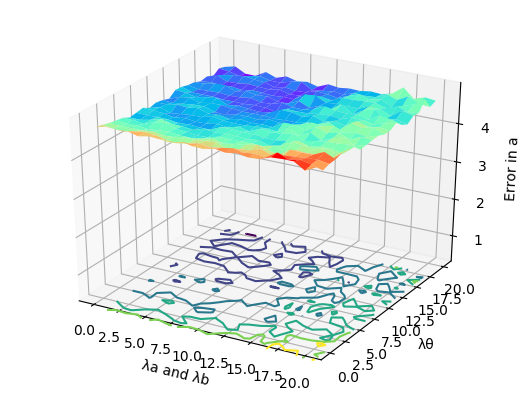

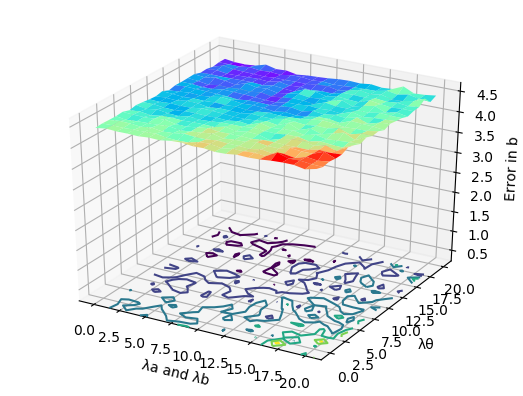

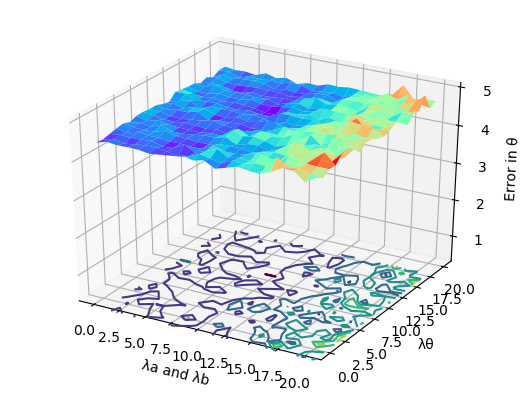

In [12]:
# Lambda values to iterate over
λabs = collect(0:1:20)
λθs = collect(0:1:20)
# Settings for the ellipse dataset
angles = collect(0:π/6:π)
datasize = 100
major_axis_size = 2
minor_axis_size = 1
noise = 0.5
variation = 0.05
x = zeros(length(λabs))
y = zeros(length(λθs))
za = zeros(length(λabs),length(λθs))
zb = zeros(length(λabs),length(λθs))
zθ = zeros(length(λabs),length(λθs))

# Enumerate over values of λab, λθ, calculating the total error.
for (i, λab) in enumerate(λabs)
    for (j, λθ) in enumerate(λθs)
        a_err = []
        b_err = []
        θ_err = []
        # Run the optimization multiple times to get a less-noisy estimate of error.
        for k in 1:50
            # Generate and fit the ellipse
            ellipses = collect(1:length(angles))
            alldata = generate_ellipses(major_axis_size,minor_axis_size,angles,datasize,noise,variation)
            a,b,θ = fit_ellipses(alldata,λab,λab,λθ)
            a_err = append!(a_err, sum(abs(major_axis_size-a[j]) for j in ellipses))
            b_err = append!(b_err, sum(abs(minor_axis_size-b[j]) for j in ellipses))
            θ_err = append!(θ_err, sum(sin(abs(angles[j]-θ[j])) for j in ellipses))
        end
        x[i] = λab
        y[j] = λθ
        za[i,j] = mean(a_err)
        zb[i,j] = mean(b_err)
        zθ[i,j] = mean(θ_err)
    end
end

# Show the graphs
figure()
title("Error in a")
surf(x,y,za+4,cmap="rainbow")
contour(x, y, za, zdir="z", 6, offset=0, origin="lower" )
xlabel("λa and λb"); ylabel("λθ"); zlabel("Error in a");
figure()
title("Error in b")
surf(x,y,zb+4,cmap="rainbow")
contour(x, y, zb, zdir="z", 6, offset=0, origin="lower" )
xlabel("λa and λb"); ylabel("λθ"); zlabel("Error in b");
figure()
title("Error in θ")
surf(x,y,zθ+4,cmap="rainbow")
contour(x, y, zθ, zdir="z", 6, offset=0, origin="lower" )
xlabel("λa and λb"); ylabel("λθ"); zlabel("Error in θ");

This shows slightly different patterns of error depending on $\lambda a$/$\lambda b$ and $\lambda \theta$. While it appears that higher values of $\lambda \theta$ are almost always preferred, visual inspection with the previously defined algorithms shows this is somewhat superficial. In practice, optimal $\lambda \theta$ seemed to hover between 2 and 6.

### 4.B To use Neighborhood Inference, or Not? ###

To obtain an experimental estimate of the above optimization's performance, and see if neighborhood inference is helpful, a set of analyses were run with varying $noise$ and $variation$ parameters. In this way, it is possible to determine the benefits/costs of adding regularization terms to the ellipse fitting procedure. For all analyses, the following settings were used: 

| Measure         | No Neighborhood Inference  | Neighborhood Inference (Regularization) |
| :-------------- |--------------------------------------|---------------------------------------|
| angles          | $0:\frac{\pi}{6}:π $                 | $0:\frac{\pi}{6}:π $                  |
| major axis      | 2                                    | 2                                     |
| minor axis      | 1                                    | 1                                     |
| datasize        | 100                                  | 100                                   |
| noise           | $0:\frac{1}{10}:1$                   | $0:\frac{1}{10}:1$                    |
| variation       | $0:\frac{1}{100}:\frac{1}{10}$       | $0:\frac{1}{100}:\frac{1}{10}$        |
| $\lambda a$     | 0                                    | 10                                    |
| $\lambda b$     | 0                                    | 10                                    |
| $\lambda \theta$| 0                                    | 3                                     |

The following code was run iterating over the above settings. Each iteration was tested each 100 times to reduce noise, but a sizeable amount of intertrial variation remains:

In [8]:
angles = collect(0:π/6:π)
# Number of samples
datasize = 100;
# Size of the major axis
major_axis_size = 2;
# Size of the minor axis
minor_axis_size = 1;
# Noise (Standard Deviation)
noise = 0.5;
# Variation between ellipses
variation = 0.02

# Set these lambda parameters
λa = 10
λb = 10
λθ = 10

a_err = []
b_err = []
θ_err = []

# Test 100 times
for i in 1:100
# Generate and fit the ellipse
    ellipses = collect(1:length(angles))
    alldata = generate_ellipses(major_axis_size,minor_axis_size,angles,datasize,noise,variation)
    a,b,θ = fit_ellipses(alldata,λa,λb,λθ)
    a_err = append!(a_err, sum(abs(major_axis_size-a[j]) for j in ellipses))
    b_err = append!(b_err, sum(abs(minor_axis_size-b[j]) for j in ellipses))
    θ_err = append!(θ_err, sum(sin(abs(angles[j]-θ[j])) for j in ellipses))
end
# Print the result in a table
resultarray = NamedArray([mean(a_err) mean(a_err) mean(θ_err)], 
                        (["Error"],["a","b","θ"]),("Error","Measure"))
println(resultarray)

1×3 Named Array{Float64,2}
Error ╲ Measure │        a         b         θ
────────────────┼─────────────────────────────
Error           │  0.49446   0.49446  0.415094


The results for running the above parameters for trials $n=100$ are as follows:

##### <p style="text-align: center;">Error with Increasing Noise, No Neighborhood Inference (Variation = 0.05)</p> #####

| Measure  | 0.0        | 0.2        | 0.4        | 0.6        | 0.8        | 1.0        |
| -------- |------------|------------|------------|------------|------------|------------|
| a        | 0.5432345  | 0.6453813  | 0.7658641  | 0.9890913  | 1.2978986  | 1.7015559  |
| b        | 0.5798396  | 0.5651072  | 0.6171600  | 0.6673208  | 0.8108289  | 0.8791551  |
| $\theta$ | 0.6058552  | 0.6022001  | 0.6449609  | 0.6414848  | 1.0322809  | 1.1322245  |

##### <p style="text-align: center;">Error with Increasing Noise, With Neighborhood Inference (Variation = 0.05)</p> #####

| Measure  | 0.0        | 0.2        | 0.4        | 0.6        | 0.8        | 1.0        |
| -------- |------------|------------|------------|------------|------------|------------|
| a        | 0.4191553  | 0.4374546  | 0.5306285  | 0.7541740  | 0.8762163  | 1.0310660  |
| b        | 0.5026664  | 0.4729730  | 0.5479752  | 0.6584296  | 0.6630928  | 0.7876616  |
| $\theta$ | 0.5550835  | 0.5372142  | 0.6570741  | 0.8082575  | 0.9251555  | 0.9730259  |

##### <p style="text-align: center;">Error with Increasing Variation, No Neighborhood Inference (Noise = 0.5)</p> #####

| Measure  | 0.00       | 0.02       | 0.04       | 0.06       | 0.08       | 0.10       |
| -------- |------------|------------|------------|------------|------------|------------|
| a        | 0.7580466  | 0.7425627  | 0.7763406  | 0.8004047  | 0.8732989  | 0.9322739  |
| b        | 0.3527726  | 0.3904903  | 0.3922411  | 0.5024690  | 0.5729727  | 0.6995663  |
| $\theta$ | 0.4050809  | 0.4329830  | 0.4416272  | 0.5131869  | 0.6355788  | 0.7068272  |

##### <p style="text-align: center;">Error with Increasing Variation, With Neighborhood Inference (Noise = 0.5)</p> #####

| Measure  | 0.00       | 0.02       | 0.04       | 0.06       | 0.08       | 0.10       |
| -------- |------------|------------|------------|------------|------------|------------|
| a        | 0.4392491  | 0.4914561  | 0.5072789  | 0.5549545  | 0.5816296  | 0.6548226  |
| b        | 0.2989475  | 0.2912623  | 0.3578654  | 0.4298117  | 0.4828034  | 0.5713690  |
| $\theta$ | 0.3704093  | 0.3995595  | 0.4528906  | 0.5266149  | 0.6216979  | 0.7087470  |

From these results, it appears that for the settings of $\lambda a$, $\lambda b$, and $\lambda \theta$, it appears that neighborhood inference has a small but relatively consistent beneficial effect on the error in estimation. Interestingly, it appears that it is most benefitial in reducing error in estimates of $a$. This is especially relevant, given the fact that in practice, most noise tends to occur along the direction of the major axis. Given this finding, I would say the neighborhood inference technique has potential for improvements in DTI processing techniques. 

### 4.C Thoughts on the Model ###

The model I have utilized in fitting these ellipses is a $L_2$-regularized non-convex, non-linear-least squares. This method was chosen due to the conceptual clarity and relevance to the DTI data collection process, as well as the ease of implementing neighborhood inference. However, there are alternative methods to fitting ellipses which fall under the convex umbrella. A method used by Fitzgibbon, Pilu and Fisher uses a generalized eigensystem to fit ellipses [(1999)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/ellipse-pami.pdf). Later research by Calafiore utilized an SDP method for fitting general ellipsoids [(2002)](https://pdfs.semanticscholar.org/fc7b/40e7a67c6cdec73241a0476bfe885bb47fd3.pdf). Theoretically, either of these methods could have been utilized for the individual ellipse fitting process. However, these utilized a cartesian representation of coordinates (which is less similar to the representation of data in DTI), and when extending to neighborhood inference, a similarity regularization by $a$, $b$, and $\theta$ values would have introduced non-linearity. Alternative measures of similarity may be applicable for this formulation, however. In the end, the non-linearity of the current method was largely mitigated by the setting of $\theta$ to be the $\phi$ corresponding to the largest $r_{obs}$. 

## 5. Conclusion ##

In this project, I present a new technique for the fitting of ellipses, applicable for the field of Diffusion Tensor Imaging (DTI) which utilizes neighborhood inference as a regularizer. Possible weights for the various regularizers are discussed, and qualified. This method shows small but consistent gains in accuracy compared to independent fitting. Due to the assumptions and simplifications built into this model, it would be interesting to consider the effect of neighborhood inference in the 3-dimensional space, with ellipsoids and up to 6 neighbors per ellipsoid. Potentially, the added number of neighbors may improve the efficacy of this tactic. Additionally, due to the non-convex nature of the current algorithm, it would be interesting to investigate alternative, possibly convex implementations more similar to the SDP method by Calafiore [(2002)](https://pdfs.semanticscholar.org/fc7b/40e7a67c6cdec73241a0476bfe885bb47fd3.pdf). Regardless, the current work lays a foundation for future work in improving the quality of DTI imaging results.
